In [1]:
import importlib
import time
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [6]:
eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_sqd_exp_1d,
    return_Corr=True,
    return_sort_ind=True)

# eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
#     dimension, dx, rho0, covariance.fft_exp_1d,
#     return_Corr=True,
#     return_sort_ind=True)

eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
# sort_ind = np.argsort(sort_ind)
# eig_val = eig_val[sort_ind]
# eig_vec = eig_vec[:, sort_ind]
# eig_val = np.fft.fftshift(eig_val)
# eig_vec = np.fft.fftshift(eig_vec, axes=1)

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(obs_size)

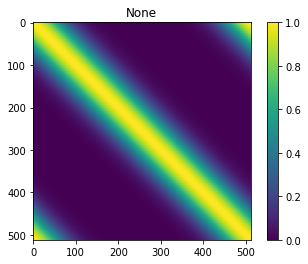

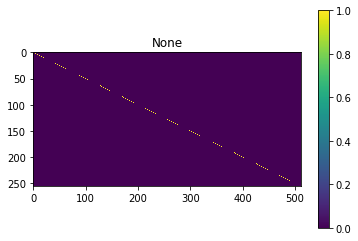

In [7]:
imshow(P, vmin=0)
imshow(H)

In [8]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


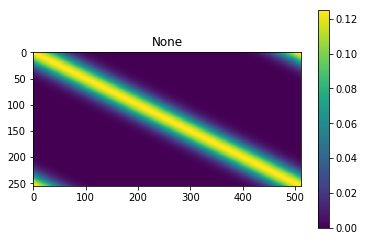

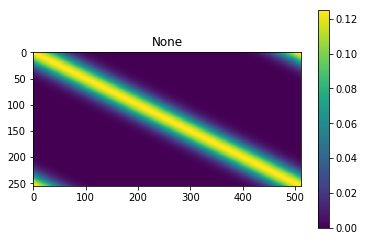

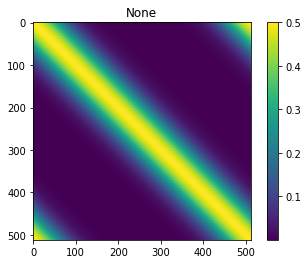

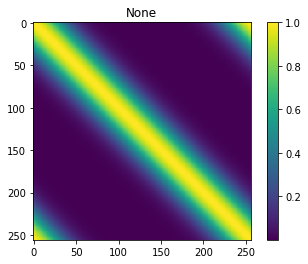

In [9]:
imshow(U @ S @ VT)
imshow(H @ P_sqrt)

imshow((H @ P_sqrt).T @ (H @ P_sqrt))

imshow((H @ P_sqrt) @ (H @ P_sqrt).T)

In [10]:
ens_ens_size = 5
ens_size = 50
sig_num = 3
mu = np.zeros(dimension)
ensemble_array = np.ones(
    [dimension, ens_size, ens_ens_size,
    ]) * np.nan
for t_num in range(ens_ens_size):
    ensemble_array[:, :, t_num] = (
        assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt']))

In [11]:
P_sample_array = np.zeros([dimension, dimension, ens_ens_size])
for i in range(ens_ens_size):
    P_sample_array[:, :, i] = np.cov(ensemble_array[:, :, i])

In [12]:
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')

# rho_array = np.linspace(.31, 0.005, 40)
rho_array = np.linspace(0.5, 0.01, 40)
# rho_array = np.linspace(.31, 0.005, 2)

s_array = np.ones([sig_num, rho_array.size, ens_ens_size]) * np.nan
U_array = np.ones([obs_size, sig_num, rho_array.size, ens_ens_size]) * np.nan
V_array = np.ones([dimension, sig_num, rho_array.size, ens_ens_size]) * np.nan

# ##
# P_var = np.ones([dimension, dimension, rho_array.size])
# P_sqrt_var = np.ones([dimension, dimension, rho_array.size])
# ##
for rho_count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    for ens_count in range(ens_ens_size):
        P_loc = P_sample_array[:, :, ens_count] * loc
    #     imshow(P_loc, f'P_loc: {rho_loc:0.3}')
        
        this_trans_mats = assimilate.transformation_matrices(
            H, P=P_loc,
            R=R, return_Ts=True)
        aU = this_trans_mats['U']
        aS = this_trans_mats['S']
        aVT = this_trans_mats['VT']
        s_array[:sig_num, rho_count, ens_count] = aS.diagonal()[:sig_num]
        U_array[:, :sig_num, rho_count, ens_count] = aU[:, :sig_num]
        V_array[:, :sig_num, rho_count, ens_count] = aVT[:sig_num, :].T
#         ##
#         P_array[:, :, ens_count] = P_loc
#         P_sqrt_array[:, :, ens_count] = this_trans_mats['P_sqrt']
#         ##
    
#     ##
#     P_var[:, :, count] = np.var(
#         P_array, axis=-1)
#     P_sqrt_var[:, :, count] = np.var(
#         P_sqrt_array, axis=-1)
#     ##   

In [13]:
reduced_true = U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num]
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')

error_n2 = np.ones([rho_array.size]) * np.nan
exp_error_n2 = np.ones([rho_array.size]) * np.nan
reduced_mean = np.ones([obs_size, dimension, rho_array.size]) * np.nan
reduced_var = np.ones([obs_size, dimension, rho_array.size]) * np.nan
mse = np.ones([obs_size, dimension, rho_array.size]) * np.nan

comb_num = round(
    math.factorial(ens_ens_size)
    / (math.factorial(2) 
       * math.factorial(ens_ens_size - 2)))

for rho_count, rho_loc in enumerate(rho_array):
    reduced_array = np.ones([obs_size,
                             dimension,
                             ens_ens_size]) * np.nan
    ens_diff_n2 = np.ones(comb_num) * np.nan
    ens_diff_count = 0
    for ens_count in range(ens_ens_size):
        aU = U_array[:, :sig_num, rho_count, ens_count]
        aS = s_array[:sig_num, rho_count, ens_count]
        aS = np.diag(aS)
        aVT = V_array[:, :sig_num, rho_count, ens_count].T
        
        reduced_array[:, :, ens_count] = (
            aU[:, :sig_num]
            @ aS[:sig_num, :sig_num]
            @ aVT[:sig_num])
        for other_ens_count in range(ens_count + 1, ens_ens_size):
            aU = U_array[:, :sig_num, rho_count, other_ens_count]
            aS = s_array[:sig_num, rho_count, other_ens_count]
            aS = np.diag(aS)
            aVT = V_array[:, :sig_num, rho_count, other_ens_count].T
            other_reduced_array = (
                aU[:, :sig_num]
                @ aS[:sig_num, :sig_num]
                @ aVT[:sig_num])
            ens_diff_n2[ens_diff_count] = sp.linalg.norm(
                reduced_array[:, :, ens_count] - other_reduced_array)
            ens_diff_count += 1
    
    reduced_mean[:, :, rho_count] = np.mean(
        reduced_array, axis=-1)
    reduced_var[:, :, rho_count] = np.var(
        reduced_array, axis=-1)
    mse[:, :, rho_count] = (
        (reduced_array - reduced_true[:, :, None])**2).mean(axis=-1)
    
#     temp_err = reduced_array - reduced_mean[:, :, rho_count][:, :, None]
#     exp_error_n2[rho_count] = sp.linalg.norm(temp_err, ord=2, axis=(0, 1)).mean()
    exp_error_n2[rho_count] = ens_diff_n2.mean()
    
#     error_n2[rho_count] = sp.linalg.norm(
#         reduced_mean[:, :, rho_count] - reduced_true,
#         ord=2)
    
    error_n2[rho_count] = sp.linalg.norm(
        reduced_array - reduced_true[:, :, None],
        ord=2, axis=(0, 1)).mean()
    

In [14]:
def angle(V0, V1):
    IPs = V0.T @ V1
    norm0 = (V0 ** 2).sum(axis=0)
    norm1 = (V1 ** 2).sum(axis=0)
    norm0 = norm0[:, None]
    norm1 = norm1[None, :]
    sigmas = sp.linalg.svd(
        IPs / np.sqrt(norm0 * norm1),
        compute_uv=False)
    dist = np.arccos(sigmas.min())
    return dist


def angle_2(V0, V1):
    norm0 = sp.linalg.norm(V0, ord=2, axis=0)
    norm1 = sp.linalg.norm(V1, ord=2, axis=0)
    V0 = V0/norm0
    V1 = V1/norm1
    IPs = V0.T @ V1
    sigmas = sp.linalg.svd(
        IPs,
        compute_uv=False)
    dist = np.arccos(sigmas)
    dist = dist.mean()
    return dist

In [15]:
true_V = VT[:sig_num].T
sample_mean_V = V_array.mean(axis=-1)
V_angle_truth2ens = np.ones(
    [1, rho_array.size, ens_ens_size]) * np.nan

comb_num = round(
    math.factorial(ens_ens_size)
    / (math.factorial(2) 
       * math.factorial(ens_ens_size - 2)))
V_average_angle = np.ones(
    rho_array.size) * np.nan
V_variance_angle = V_average_angle.copy()
for rho_count in range(rho_array.size):
    angle_count = 0
    angles = np.ones(comb_num) * np.nan
    for ens_count in range(ens_ens_size):
        aV = V_array[:, :, rho_count, ens_count]
        V_dist = angle_2(aV, true_V)
        V_angle_truth2ens[0, rho_count, ens_count] = V_dist
        for other_ens_count in range(ens_count + 1, ens_ens_size):
            oV = V_array[:, :, rho_count, other_ens_count]
            V_dist = angle_2(aV, oV)
            angles[angle_count] = V_dist
            angle_count += 1
    V_average_angle[rho_count] = angles.mean()
    V_variance_angle[rho_count] = angles.var()
V_angle_truth2ens_var = V_angle_truth2ens.var(axis=-1)
V_angle_truth2ens_mean = V_angle_truth2ens.mean(axis=-1)

Ens size: 50 

Ens of ens size: 5 

Number of singular values: 3 

Minimize expected norm2 error: 0.1733
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.2236 

Minimize average angle among ensembles: 0.2487 

Minimize average angle from truth: 0.2362 



Text(0.5,1,'Mean of angle')

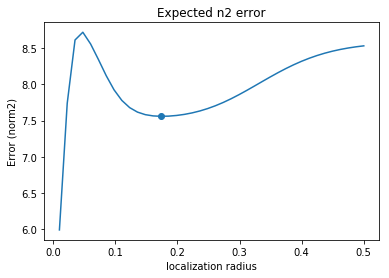

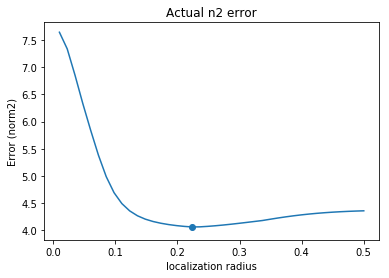

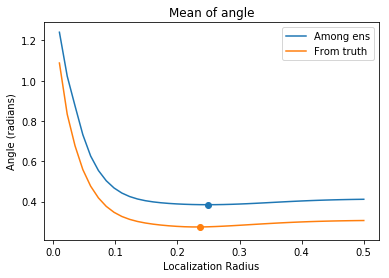

In [16]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2[:-3].argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

In [17]:
opt_s = np.ones([sig_num, ens_ens_size]) * np.nan
opt_U = np.ones([obs_size, sig_num, ens_ens_size]) * np.nan
opt_V = np.ones([dimension, sig_num, ens_ens_size]) * np.nan

opt_loc = rho_array[ea_arg]

[loc] = covariance.generate_circulant(
    dimension, dx, opt_loc, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
loc /= loc.max()
for ens_count in range(ens_ens_size):
    P_loc = P_sample_array[:, :, ens_count] * loc
#     imshow(P_loc, f'P_loc: {rho_loc:0.3}')

    this_trans_mats = assimilate.transformation_matrices(
        H, P=P_loc,
        R=R, return_Ts=True)
    aU = this_trans_mats['U']
    aS = this_trans_mats['S']
    aVT = this_trans_mats['VT']
    opt_s[:sig_num, ens_count] = aS.diagonal()[:sig_num]
    opt_U[:, :sig_num, ens_count] = aU[:, :sig_num]
    opt_V[:, :sig_num, ens_count] = aVT[:sig_num, :].T
final_trans_mats = this_trans_mats.copy()

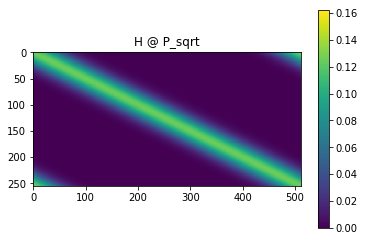

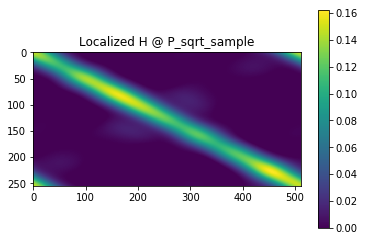

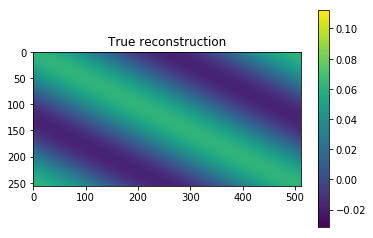

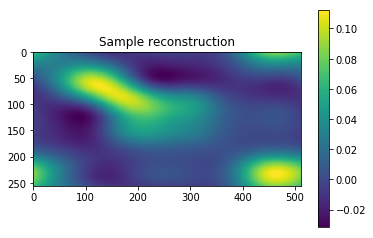

In [18]:
vmax = np.max([(H @ P_sqrt).max(),
               (H @ final_trans_mats['P_sqrt']).max()])
imshow(H @ P_sqrt, 'H @ P_sqrt',
       vmin=0, vmax=vmax)
imshow(H @ final_trans_mats['P_sqrt'],
       'Localized H @ P_sqrt_sample',
       vmin=0, vmax=vmax)

this_true_recon = (U[:, :sig_num]
                   @ S[:sig_num, :sig_num]
                   @ VT[:sig_num])
this_sample_recon = (opt_U[:, :, -1]
                     @ np.diag(opt_s[:, -1])
                     @ opt_V[:, :, -1].T)
vmax = np.max([this_true_recon.max(),
               this_sample_recon.max()])
vmin = np.min([this_true_recon.min(),
               this_sample_recon.min()])
imshow(this_true_recon,
       'True reconstruction',
       vmin=vmin, vmax=vmax)
imshow(this_sample_recon,
       'Sample reconstruction',
       vmin=vmin, vmax=vmax)

In [19]:
a_ensemble = ensemble_array[:, :, -1]
a_P_sample = P_sample_array[:, :, -1]

In [20]:
HP_orth = ((H @ P_sqrt)
           @ (np.eye(dimension)
              - VT[:sig_num].T
              @ VT[:sig_num]))
HP_sample_orth_loc = ((H @ final_trans_mats['P_sqrt'])
                  @ (np.eye(dimension)
                     - opt_V[:, :, -1]
                     @ opt_V[:, :, -1].T))
# vmax = np.max([HP_orth.max(),
#                HP_sample_orth_loc.max()])
# vmin = np.min([HP_orth.min(),
#                HP_sample_orth_loc.min()])
# imshow(HP_orth, vmax=vmax, vmin=vmin)
# imshow(HP_sample_orth_loc, vmax=vmax, vmin=vmin)

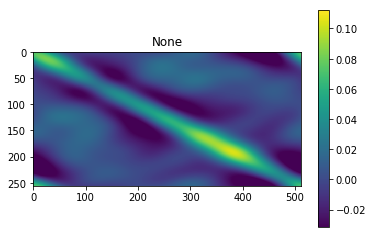

In [21]:
this_trans_mats = assimilate.transformation_matrices(
    H=H, P=a_P_sample, R=R)

a_P_sqrt_sample = this_trans_mats['P_sqrt']

HP_sample_orth = ((H @ a_P_sqrt_sample)
                   @ (np.eye(dimension)
                      - opt_V[:, :, -1]
                      @ opt_V[:, :, -1].T))
imshow(HP_sample_orth, vmax=vmax, vmin=vmin)

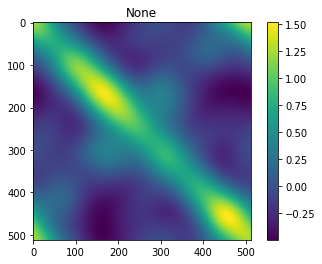

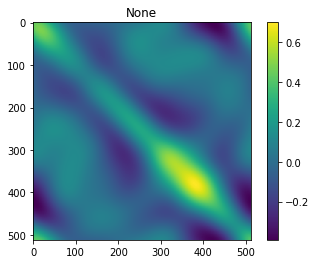

In [22]:
proj = (np.eye(dimension)
        - opt_V[:, :, -1] @ opt_V[:, :, -1].T)
# mu = np.mean(a_ensemble, axis=-1)
# a_ensemble_proj = mu[:, None] + proj @ (a_ensemble - mu[:, None])
a_ensemble_proj = proj @ a_ensemble
P_sample_proj = np.cov(a_ensemble_proj)
imshow(a_P_sample)
imshow(P_sample_proj)

In [23]:
this_trans_mats = assimilate.transformation_matrices(
    H, P=P_sample_proj,
    R=R, return_Ts=True)
U_orth = this_trans_mats['U']
S_orth = this_trans_mats['S']
VT_orth = this_trans_mats['VT']
P_sqrt_orth = this_trans_mats['P_sqrt']
P_sqrt_orth = 0.5 * (P_sqrt_orth + P_sqrt_orth.T)

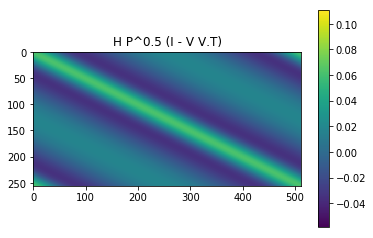

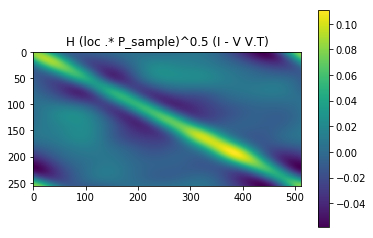

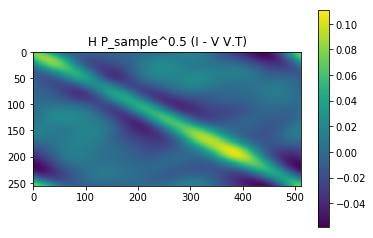

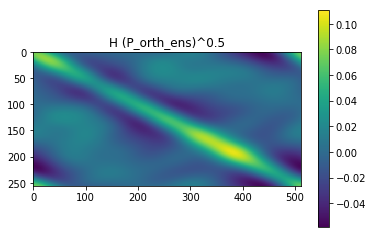

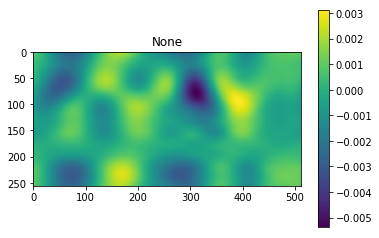

In [24]:
# HP_sample_orth_recon = (U_orth
#                         @ S_orth
#                         @ VT_orth)
HP_sample_orth_recon = H @ P_sqrt_orth
vmax = np.max([HP_orth.max(),
               HP_sample_orth.max(),
               HP_sample_orth_loc.max(),
               HP_sample_orth_recon.max()])
vmin = np.min([HP_orth.min(),
               HP_sample_orth.min(),
               HP_sample_orth_loc.min(),
               HP_sample_orth_recon.min()])

imshow(HP_orth,
       'H P^0.5 (I - V V.T)',
       vmax=vmax, vmin=vmin)
imshow(HP_sample_orth_loc,
       'H (loc .* P_sample)^0.5 (I - V V.T)',
       vmax=vmax, vmin=vmin)
imshow(HP_sample_orth,
       'H P_sample^0.5 (I - V V.T)',
       vmax=vmax, vmin=vmin)
imshow(HP_sample_orth_recon,
       'H (P_orth_ens)^0.5',
       vmax=vmax, vmin=vmin)

imshow(HP_sample_orth_recon - HP_sample_orth)

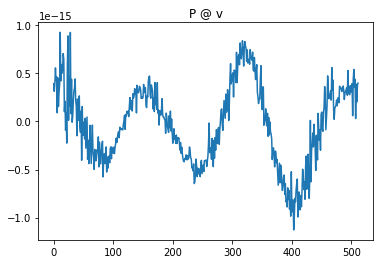

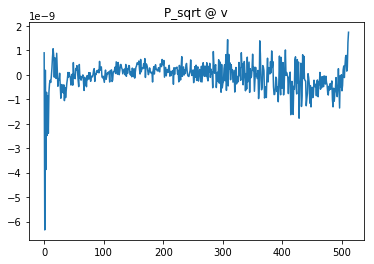

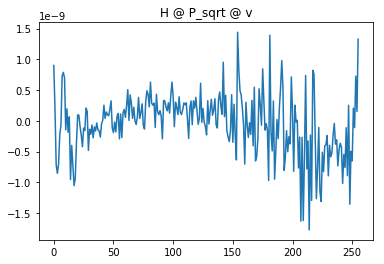

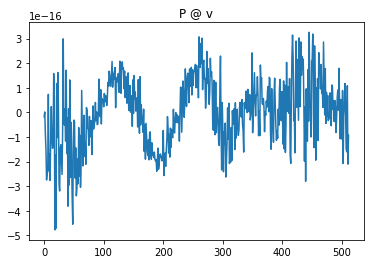

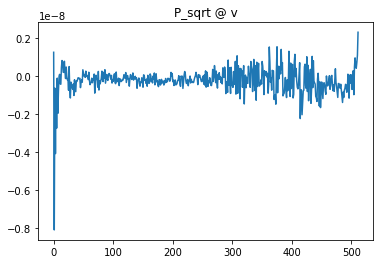

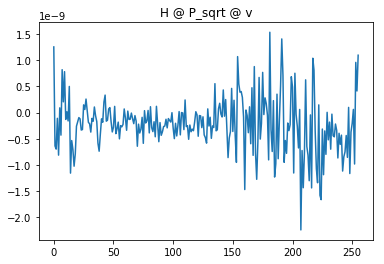

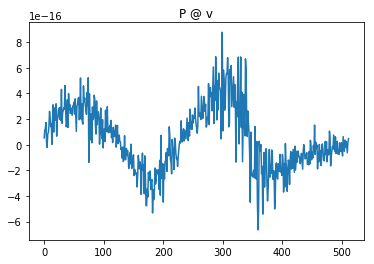

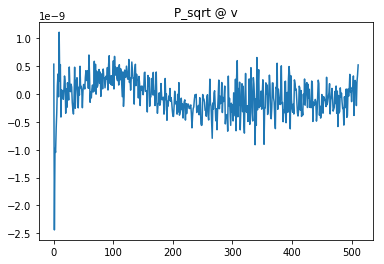

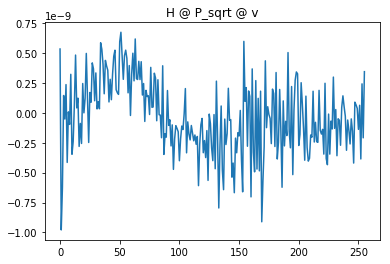

In [25]:
for ii in range(sig_num):
#     plt.figure()
#     plt.plot(proj @ opt_V[:, ii, -1])
    
    plt.figure()
    plt.plot(P_sample_proj @ opt_V[:, ii, -1])
    plt.title('P @ v')
    
    plt.figure()
    plt.plot(P_sqrt_orth @ opt_V[:, ii, -1])
    plt.title('P_sqrt @ v')
    
    plt.figure()
    plt.plot(HP_sample_orth_recon @ opt_V[:, ii, -1])
    plt.title('H @ P_sqrt @ v')
    
#     plt.figure()
#     plt.plot(HP_sample_orth @ opt_V[:, ii, -1])
    
#     plt.figure()
#     plt.plot(HP_sample_orth_loc @ opt_V[:, ii, -1])

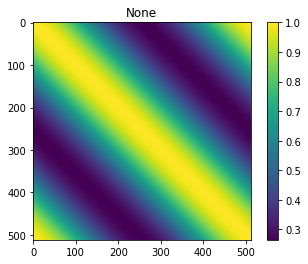

In [26]:
imshow(loc)

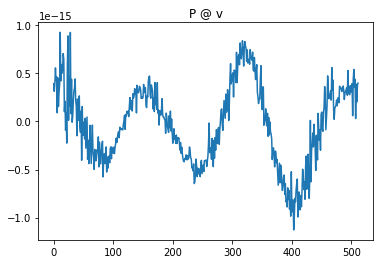

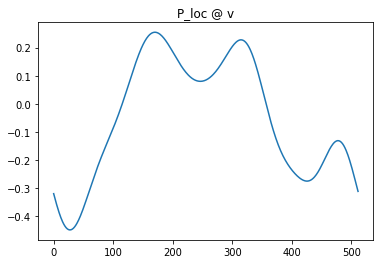

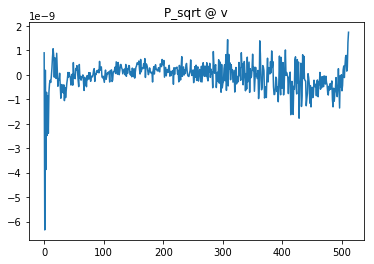

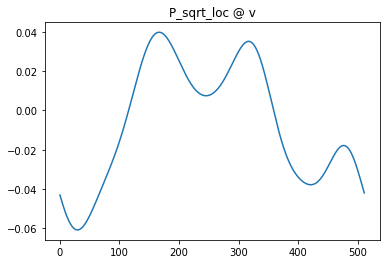

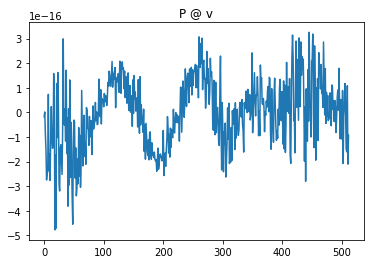

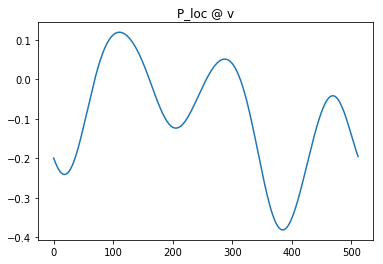

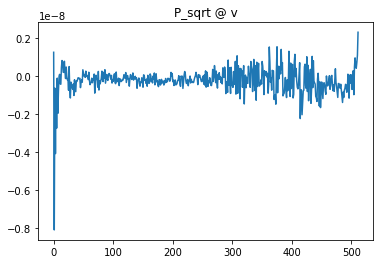

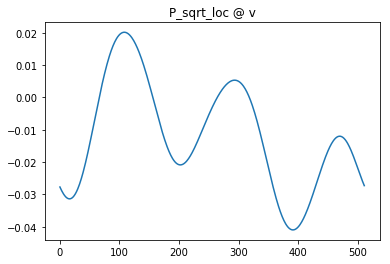

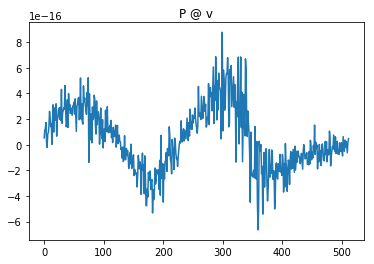

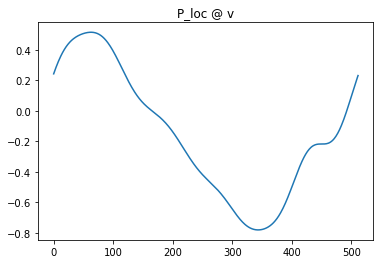

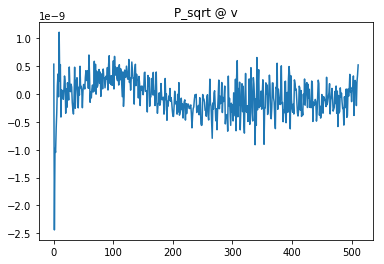

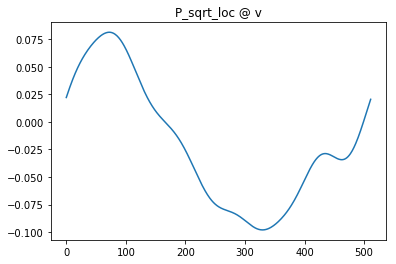

In [28]:
for ii in range(sig_num):
#     plt.figure()
#     plt.plot(proj @ opt_V[:, ii, -1])
    
    plt.figure()
    plt.plot(P_sample_proj @ opt_V[:, ii, -1])
    plt.title('P @ v')
    
    plt.figure()
    plt.plot((P_sample_proj * loc) @ opt_V[:, ii, -1])
    plt.title('P_loc @ v')

    plt.figure()
    plt.plot(P_sqrt_orth @ opt_V[:, ii, -1])
    plt.title('P_sqrt @ v')
    
    plt.figure()
    plt.plot((P_sqrt_orth * loc) @ opt_V[:, ii, -1])
    plt.title('P_sqrt_loc @ v')
    
#     plt.figure()
#     plt.plot(HP_sample_orth_recon @ opt_V[:, ii, -1])
#     plt.title('H @ P_sqrt @ v')
    
#     plt.figure()
#     plt.plot(HP_sample_orth @ opt_V[:, ii, -1])
    
#     plt.figure()
#     plt.plot(HP_sample_orth_loc @ opt_V[:, ii, -1])

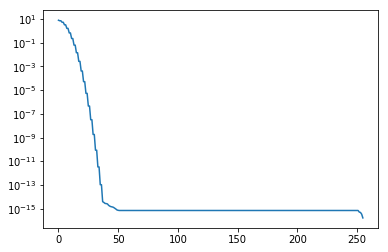

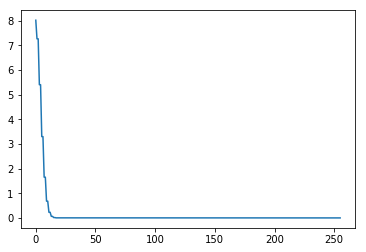

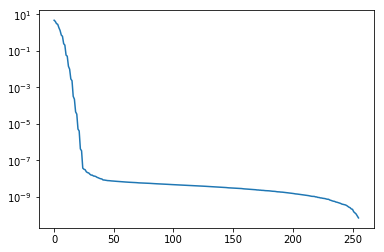

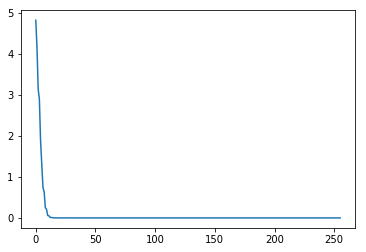

In [26]:
plt.figure()
plt.semilogy(S.diagonal())

plt.figure()
plt.plot(S.diagonal())

plt.figure()
plt.semilogy(S_orth.diagonal())

plt.figure()
plt.plot(S_orth.diagonal())

# plt.figure()
# plt.semilogy(S_orth.diagonal()[-10:])

In [27]:
print(S.diagonal()[:10])
print(S_orth.diagonal()[:10])

[8.01059822 7.25774662 7.25774662 5.39774496 5.39774496 3.29531264
 3.29531264 1.65140879 1.65140879 0.67933856]
[4.82231385 4.15313853 3.13922719 2.89839233 1.88279369 1.32587788
 0.7451852  0.63385877 0.25013864 0.20878562]


In [28]:
proj_array = np.ones(
    [dimension, dimension, ens_ens_size]) * np.nan
for ens_ens_num in range(ens_ens_size):
    proj_array[:, :, ens_ens_num] = (np.eye(dimension)
        - opt_V[:, :, ens_ens_num] @ opt_V[:, :, ens_ens_num].T)

In [29]:
sig_num2 = 4
# rho_array = np.linspace(.31, 0.005, 40)
rho_array = np.linspace(0.5, 0.01, 40)
# rho_array = np.linspace(.31, 0.005, 2)

s_array = np.ones([sig_num2, rho_array.size, ens_ens_size]) * np.nan
U_array = np.ones([obs_size, sig_num2, rho_array.size, ens_ens_size]) * np.nan
V_array = np.ones([dimension, sig_num2, rho_array.size, ens_ens_size]) * np.nan

# ##
# P_var = np.ones([dimension, dimension, rho_array.size])
# P_sqrt_var = np.ones([dimension, dimension, rho_array.size])
# ##
for rho_count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    for ens_count in range(ens_ens_size):
        P_loc = P_sample_array[:, :, ens_count] * loc @ proj_array[:, :, ens_ens_num]
    #     imshow(P_loc, f'P_loc: {rho_loc:0.3}')
        
        this_trans_mats = assimilate.transformation_matrices(
            H, P=P_loc,
            R=R, return_Ts=True)
        aU = this_trans_mats['U']
        aS = this_trans_mats['S']
        aVT = this_trans_mats['VT']
        s_array[:sig_num2, rho_count, ens_count] = aS.diagonal()[:sig_num2]
        U_array[:, :sig_num2, rho_count, ens_count] = aU[:, :sig_num2]
        V_array[:, :sig_num2, rho_count, ens_count] = aVT[:sig_num2, :].T
#         ##
#         P_array[:, :, ens_count] = P_loc
#         P_sqrt_array[:, :, ens_count] = this_trans_mats['P_sqrt']
#         ##
    
#     ##
#     P_var[:, :, count] = np.var(
#         P_array, axis=-1)
#     P_sqrt_var[:, :, count] = np.var(
#         P_sqrt_array, axis=-1)
#     ##   

In [30]:
sig_slice = slice(sig_num, sig_num + sig_num2)
reduced_true = U[:, sig_slice] @ S[sig_slice, sig_slice] @ VT[sig_slice]
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')

error_n2 = np.ones([rho_array.size]) * np.nan
exp_error_n2 = np.ones([rho_array.size]) * np.nan
reduced_mean = np.ones([obs_size, dimension, rho_array.size]) * np.nan
reduced_var = np.ones([obs_size, dimension, rho_array.size]) * np.nan
mse = np.ones([obs_size, dimension, rho_array.size]) * np.nan

comb_num = round(
    math.factorial(ens_ens_size)
    / (math.factorial(2) 
       * math.factorial(ens_ens_size - 2)))

for rho_count, rho_loc in enumerate(rho_array):
    reduced_array = np.ones([obs_size,
                             dimension,
                             ens_ens_size]) * np.nan
    ens_diff_n2 = np.ones(comb_num) * np.nan
    ens_diff_count = 0
    for ens_count in range(ens_ens_size):
        aU = U_array[:, :sig_num2, rho_count, ens_count]
        aS = s_array[:sig_num2, rho_count, ens_count]
        aS = np.diag(aS)
        aVT = V_array[:, :sig_num2, rho_count, ens_count].T
        
        reduced_array[:, :, ens_count] = (
            aU[:, :sig_num2]
            @ aS[:sig_num2, :sig_num2]
            @ aVT[:sig_num2])
        for other_ens_count in range(ens_count + 1, ens_ens_size):
            aU = U_array[:, :sig_num2, rho_count, other_ens_count]
            aS = s_array[:sig_num2, rho_count, other_ens_count]
            aS = np.diag(aS)
            aVT = V_array[:, :sig_num2, rho_count, other_ens_count].T
            other_reduced_array = (
                aU[:, :sig_num2]
                @ aS[:sig_num2, :sig_num2]
                @ aVT[:sig_num2])
            ens_diff_n2[ens_diff_count] = sp.linalg.norm(
                reduced_array[:, :, ens_count] - other_reduced_array)
            ens_diff_count += 1
    
    reduced_mean[:, :, rho_count] = np.mean(
        reduced_array, axis=-1)
    reduced_var[:, :, rho_count] = np.var(
        reduced_array, axis=-1)
    mse[:, :, rho_count] = (
        (reduced_array - reduced_true[:, :, None])**2).mean(axis=-1)
    
#     temp_err = reduced_array - reduced_mean[:, :, rho_count][:, :, None]
#     exp_error_n2[rho_count] = sp.linalg.norm(temp_err, ord=2, axis=(0, 1)).mean()
    exp_error_n2[rho_count] = ens_diff_n2.mean()
    
#     error_n2[rho_count] = sp.linalg.norm(
#         reduced_mean[:, :, rho_count] - reduced_true,
#         ord=2)
    
    error_n2[rho_count] = sp.linalg.norm(
        reduced_array - reduced_true[:, :, None],
        ord=2, axis=(0, 1)).mean()
    

In [31]:
def angle(V0, V1):
    IPs = V0.T @ V1
    norm0 = (V0 ** 2).sum(axis=0)
    norm1 = (V1 ** 2).sum(axis=0)
    norm0 = norm0[:, None]
    norm1 = norm1[None, :]
    sigmas = sp.linalg.svd(
        IPs / np.sqrt(norm0 * norm1),
        compute_uv=False)
    dist = np.arccos(sigmas.min())
    return dist


def angle_2(V0, V1):
    norm0 = sp.linalg.norm(V0, ord=2, axis=0)
    norm1 = sp.linalg.norm(V1, ord=2, axis=0)
    V0 = V0/norm0
    V1 = V1/norm1
    IPs = V0.T @ V1
    sigmas = sp.linalg.svd(
        IPs,
        compute_uv=False)
    dist = np.arccos(sigmas)
    dist = dist.mean()
    return dist

In [32]:
true_V = VT[sig_slice].T
sample_mean_V = V_array.mean(axis=-1)
V_angle_truth2ens = np.ones(
    [1, rho_array.size, ens_ens_size]) * np.nan

comb_num = round(
    math.factorial(ens_ens_size)
    / (math.factorial(2) 
       * math.factorial(ens_ens_size - 2)))
V_average_angle = np.ones(
    rho_array.size) * np.nan
V_variance_angle = V_average_angle.copy()
for rho_count in range(rho_array.size):
    angle_count = 0
    angles = np.ones(comb_num) * np.nan
    for ens_count in range(ens_ens_size):
        aV = V_array[:, :, rho_count, ens_count]
        V_dist = angle_2(aV, true_V)
        V_angle_truth2ens[0, rho_count, ens_count] = V_dist
        for other_ens_count in range(ens_count + 1, ens_ens_size):
            oV = V_array[:, :, rho_count, other_ens_count]
            V_dist = angle_2(aV, oV)
            angles[angle_count] = V_dist
            angle_count += 1
    V_average_angle[rho_count] = angles.mean()
    V_variance_angle[rho_count] = angles.var()
V_angle_truth2ens_var = V_angle_truth2ens.var(axis=-1)
V_angle_truth2ens_mean = V_angle_truth2ens.mean(axis=-1)

Ens size: 50 

Ens of ens size: 5 

Number of singular values: 3 

Minimize expected norm2 error: 0.1231
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.1105 

Minimize average angle among ensembles: 0.1231 

Minimize average angle from truth: 0.1105 



Text(0.5,1,'Mean of angle')

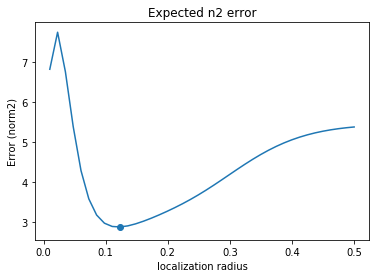

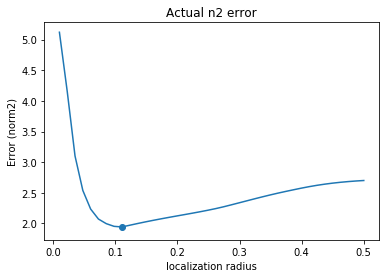

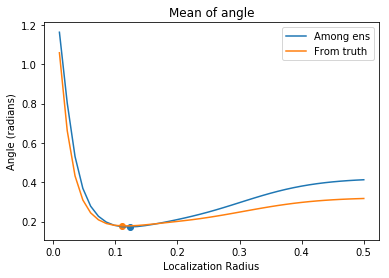

In [33]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2[:-3].argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

In [34]:
opt_s = np.ones([sig_num2, ens_ens_size]) * np.nan
opt_U = np.ones([obs_size, sig_num2, ens_ens_size]) * np.nan
opt_V = np.ones([dimension, sig_num2, ens_ens_size]) * np.nan

opt_loc = rho_array[ea_arg]

[loc] = covariance.generate_circulant(
    dimension, dx, opt_loc, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
loc /= loc.max()
for ens_count in range(ens_ens_size):
    P_loc = P_sample_array[:, :, ens_count] * loc @ proj_array[:, :, ens_ens_num]
#     imshow(P_loc, f'P_loc: {rho_loc:0.3}')

    this_trans_mats = assimilate.transformation_matrices(
        H, P=P_loc,
        R=R, return_Ts=True)
    aU = this_trans_mats['U']
    aS = this_trans_mats['S']
    aVT = this_trans_mats['VT']
    opt_s[:sig_num2, ens_count] = aS.diagonal()[:sig_num2]
    opt_U[:, :sig_num2, ens_count] = aU[:, :sig_num2]
    opt_V[:, :sig_num2, ens_count] = aVT[:sig_num2, :].T
final_trans_mats = this_trans_mats.copy()

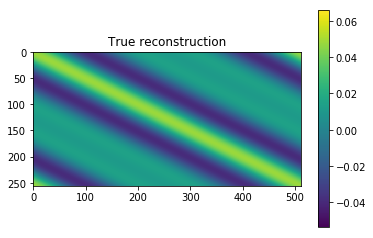

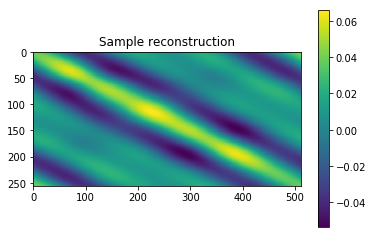

In [35]:
# vmax = np.max([(H @ P_sqrt).max(),
#                (H @ final_trans_mats['P_sqrt']).max()])
# imshow(H @ P_sqrt, 'H @ P_sqrt',
#        vmin=0, vmax=vmax)
# imshow(H @ final_trans_mats['P_sqrt'],
#        'Localized H @ P_sqrt_sample',
#        vmin=0, vmax=vmax)

this_true_recon = (U[:, sig_slice]
                   @ S[sig_slice, sig_slice]
                   @ VT[sig_slice])
this_sample_recon = (opt_U[:, :, -1]
                     @ np.diag(opt_s[:, -1])
                     @ opt_V[:, :, -1].T)
vmax = np.max([this_true_recon.max(),
               this_sample_recon.max()])
vmin = np.min([this_true_recon.min(),
               this_sample_recon.min()])
imshow(this_true_recon,
       'True reconstruction',
       vmin=vmin, vmax=vmax)
imshow(this_sample_recon,
       'Sample reconstruction',
       vmin=vmin, vmax=vmax)

In [36]:
proj2 = (np.eye(dimension)
         - opt_V[:, :, -1] @ opt_V[:, :, -1].T)

In [37]:
proj_true = (np.eye(dimension) - VT[:sig_num].T @ VT[:sig_num])
proj2_true = (np.eye(dimension) - VT[sig_slice].T @ VT[sig_slice])

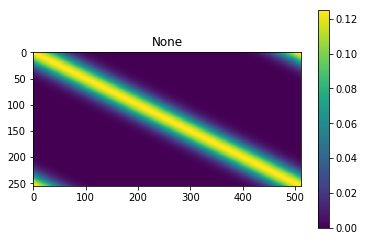

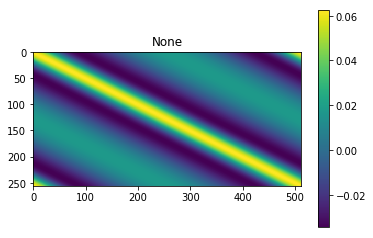

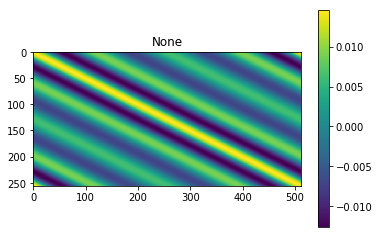

In [38]:
imshow(H @ P_sqrt)
imshow(H @ P_sqrt @ proj_true)
imshow(H @ P_sqrt @ proj_true @ proj2_true)

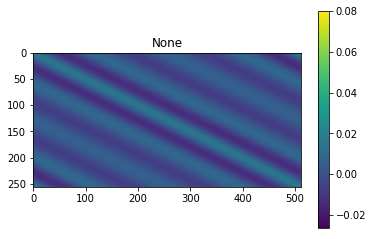

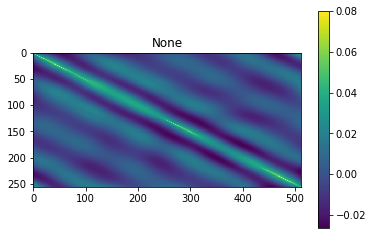

In [39]:
HP_orth = ((H @ P_sqrt)
           @ proj_true @ proj2_true)
HP_sample_orth_loc = (
    (H @ final_trans_mats['P_sqrt'])
     @ proj2)
vmax = np.max([HP_orth.max(),
               HP_sample_orth_loc.max()])
vmin = np.min([HP_orth.min(),
               HP_sample_orth_loc.min()])
imshow(HP_orth, vmax=vmax, vmin=vmin)
imshow(HP_sample_orth_loc, vmax=vmax, vmin=vmin)

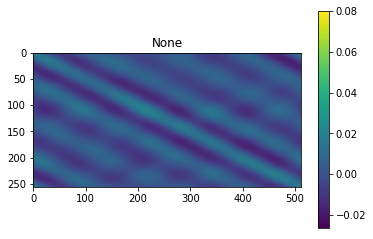

In [40]:
HP_sample_orth = ((H @ a_P_sqrt_sample)
                   @ proj @ proj2)
imshow(HP_sample_orth, vmax=vmax, vmin=vmin)

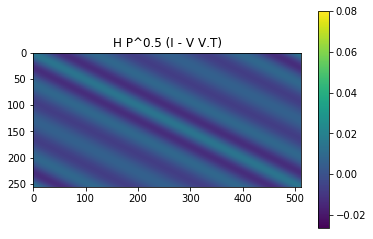

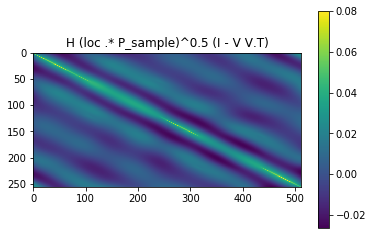

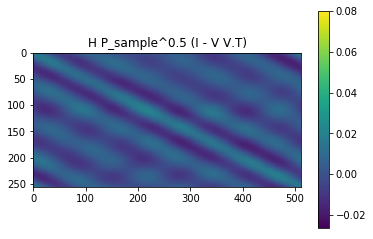

In [41]:
# HP_sample_orth_recon = (U_orth
#                         @ S_orth
#                         @ VT_orth)
# HP_sample_orth_recon = H @ P_sqrt_orth
vmax = np.max([HP_orth.max(),
               HP_sample_orth.max(),
               HP_sample_orth_loc.max()])
vmin = np.min([HP_orth.min(),
               HP_sample_orth.min(),
               HP_sample_orth_loc.min()])

imshow(HP_orth,
       'H P^0.5 (I - V V.T)',
       vmax=vmax, vmin=vmin)
imshow(HP_sample_orth_loc,
       'H (loc .* P_sample)^0.5 (I - V V.T)',
       vmax=vmax, vmin=vmin)
imshow(HP_sample_orth,
       'H P_sample^0.5 (I - V V.T)',
       vmax=vmax, vmin=vmin)